# More on Spam filtering using Naive Bayes

This small notebook explores more the performance of the Naive Bayes algorithm implemented in my previous notebook **"Spam filtering using Naive Bayes"**. In particular, besides the confusion matrix obtained previously, we also obtain:
* precision, recall, f1-score (through the `classification_report`);
* ROC curve;
* precision-recall curve.

I'll explore the detail and motivation of these metrics in a ***blog post***.

First, we repeat the same steps to read the data, create the feature vectors and implement the algorithm using `sklearn`. For the details, check the previous notebook.

## Read the data and implement Naive Bayes

### Read the data

In [1]:
import numpy as np

data = np.load('data/lingspam/lingspam.npz')

In [2]:
from collections import Counter, OrderedDict

# create a dictionary with each word as the key and the number of occurences as the value
cnt = Counter()
total_words = 0
for entry in data['words']:
    total_words += len(entry)    # total number of words in the dataset
    for word in entry:
        cnt[word] += 1

# order the previous dictionary by most common words
ordered_cnt = OrderedDict(cnt.most_common())

In [3]:
num_words_threshold = 9451

In [4]:
unique_words_90 = list(OrderedDict(cnt.most_common(num_words_threshold)).keys())

### Create the features

In [5]:
def create_feature(list):
    
    # list with words from list which are in the unique_words_90 list
    words_in_unique_list = [word for word in list if word in unique_words_90]
    
    # dictionary created from previous list counting the number of occurences
    words_in_unique_dict = Counter(words_in_unique_list)
    
    # array of zeros, with the same number of elements as the unique_words_90 list
    features = np.zeros(len(unique_words_90), dtype=np.uint32)
    
    # for each word:occurence in dictionary, save occurence in the correct slot of features
    for word, occurence in words_in_unique_dict.items():
        features[unique_words_90.index(word)] = occurence
    
    return features

In [6]:
# creates a matrix of zeros with dimensions of (number of targets)x(number of unique words)
X = np.empty((len(data['targets']), len(unique_words_90)), dtype=np.uint32)

# use function create_feature for each row
for i, email in enumerate(data['words']):
    X[i,:] = create_feature(email)

In [7]:
y = data['targets']

### Implement Naive Bayes

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (2025, 9451)
X_test:  (868, 9451)
y_train:  (2025,)
y_test:  (868,)


In [9]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

## Mode performance

### Accuracy

In [10]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9907834101382489


### Confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[724   7]
 [  1 136]]


From the confusion matrix, we see that the Naive Bayes classifier got the following results:
* Out of the 731 actual instances of 'ham' (not spam), it predicted correctly 724 of them;
* Out of the 137 actual instances of spam, it predicted correctly 136 of them.

Note that the accuracy may be obtained from the confusion matrix, as the sum of the diagonal divided by the sum of all matrix entries:

In [12]:
(cm[0,0]+cm[1,1])/np.sum(cm)

0.9907834101382489

### Precision, recall and f1-score

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       1.00      0.99      0.99       731
       True       0.95      0.99      0.97       137

avg / total       0.99      0.99      0.99       868



### ROC curve

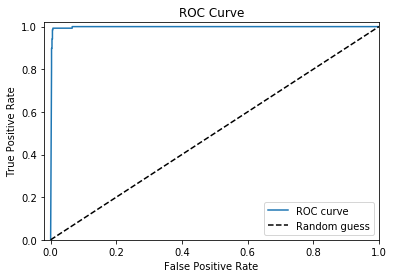

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_prob = nb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

# save figure
plt.savefig('roc_curve.png', dpi=200)

In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_prob) 

0.9977033760372253

### Precision-recall curve

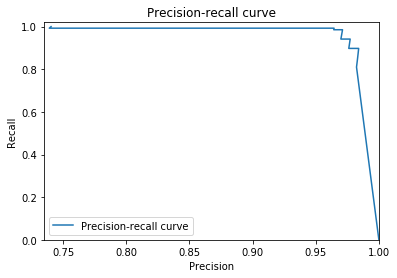

In [16]:
from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.xlim([0.735, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower left")

# save figure
plt.savefig('precision_recall.png', dpi=200)

In [17]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test, y_pred_prob) 

0.9797416137620364